# Machine Learning - SF vs NYC Housing 
#### Going Down the EECS Stack DeCal Spring 2017
Data courtesy of [r2d3](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/)
<img src="https://grapecollective.com/media/article/image/cache/720x337-center/c/o/comparison.jpg">

In this notebook, we'll explore some ideas behind machine learning using housing data from San Francisco and New York. </br>
Each data point corresponds to a house with the following fields:
- year_built (int, e.g. 1990)
- price_per_sqft (int, dollars)
- bath (float)
- beds (float)
- elevation (int, ft)
- price (int, dollars)
- in_sf (int, 1 if in sf, 0 otherwise)

In the first part of this notebook we'll try to classify houses and predict whether a house is from NYC or SF. In the second part we'll try to regress and predict the prices of the houses.

<br />
Mathy Notation for later parts:
- $n$ denotes the number of data points (houses) 
- $d$ denotes the number of features 
- $X$ is an $n \times d$ matrix, where each row corresponds to a house. $X_i$ means the $i$th row, or the $i$th feature vector.
- $y$ is a length $n$ vector, where each index corresponds to a label. $y_i$ means the label for the $i$th house. For part 1 the labels are either $1$ or $0$ for SF and NYC respectively. For part 2 the labels are real numbers denoting housing price.


In [1]:
# imports
import numpy as np
%matplotlib notebook
from sklearn.metrics import mean_absolute_error, r2_score
from IPython.display import clear_output
from time import sleep
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from util3 import extract_cols, visualize_linear_regression, visualize_perceptron, load_data
import matplotlib.pyplot as plt

In [2]:
# load housing data
all_data, features_c, labels_c, features_r, labels_r = load_data()

## Part 1: Classification: NYC vs SF
In this section, our goal is to learn a model that predicts whether a given house is from SF or from NYC. Our label is "is_sf", which is 1 if the house belongs to SF, 0 if NYC.

### Part 1.1 Manual Classification
1. Use the cells below to explore statistics about the housing data. Note the mean and range of certain features. Which feature helps differentiating nyc and sf houses the most?
2. Use your knowledge about the data to fill in the function "is_in_sf," which takes in a feature dictionary and returns 1 if you think this house belongs in SF, 0 if it belongs to NY
3. Test how good your result is. Try to improve your score as much as possible!

In [3]:
def plot_housing_histogram(feature_name):
    '''
    statistic is either 'mean', 'std', 'min', 'max'
    feel free to modify this function to explore other properties about the housing data.
    '''
    if feature_name not in features_c[0]:
        raise ValueError("Invalid feature_name!")
        
    sf = []
    nyc = []
    for data in all_data:
        if data['in_sf']:
            sf.append(data[feature_name])
        else:
            nyc.append(data[feature_name])
    
    plt.figure()
    bins = np.histogram(np.hstack((sf, nyc)), bins=50)[1]
    plt.hist(sf, bins, alpha=0.5, facecolor='red', label='SF')
    plt.hist(nyc, bins, alpha=0.5, facecolor='blue', label='NYC')
    plt.xlabel(feature_name)
    plt.ylabel('number of houses')
    plt.title('Histogram of SF and NYC Houses by {}'.format(feature_name))
    plt.legend()
    
    print('SF | mean: {}, std: {}, min: {}, max: {}'.format(np.mean(sf), np.std(sf), min(sf), max(sf)))
    print('NYC | mean: {}, std: {}, min: {}, max: {}'.format(np.mean(nyc), np.std(nyc), min(nyc), max(nyc)))   

<IPython.core.display.Javascript object>


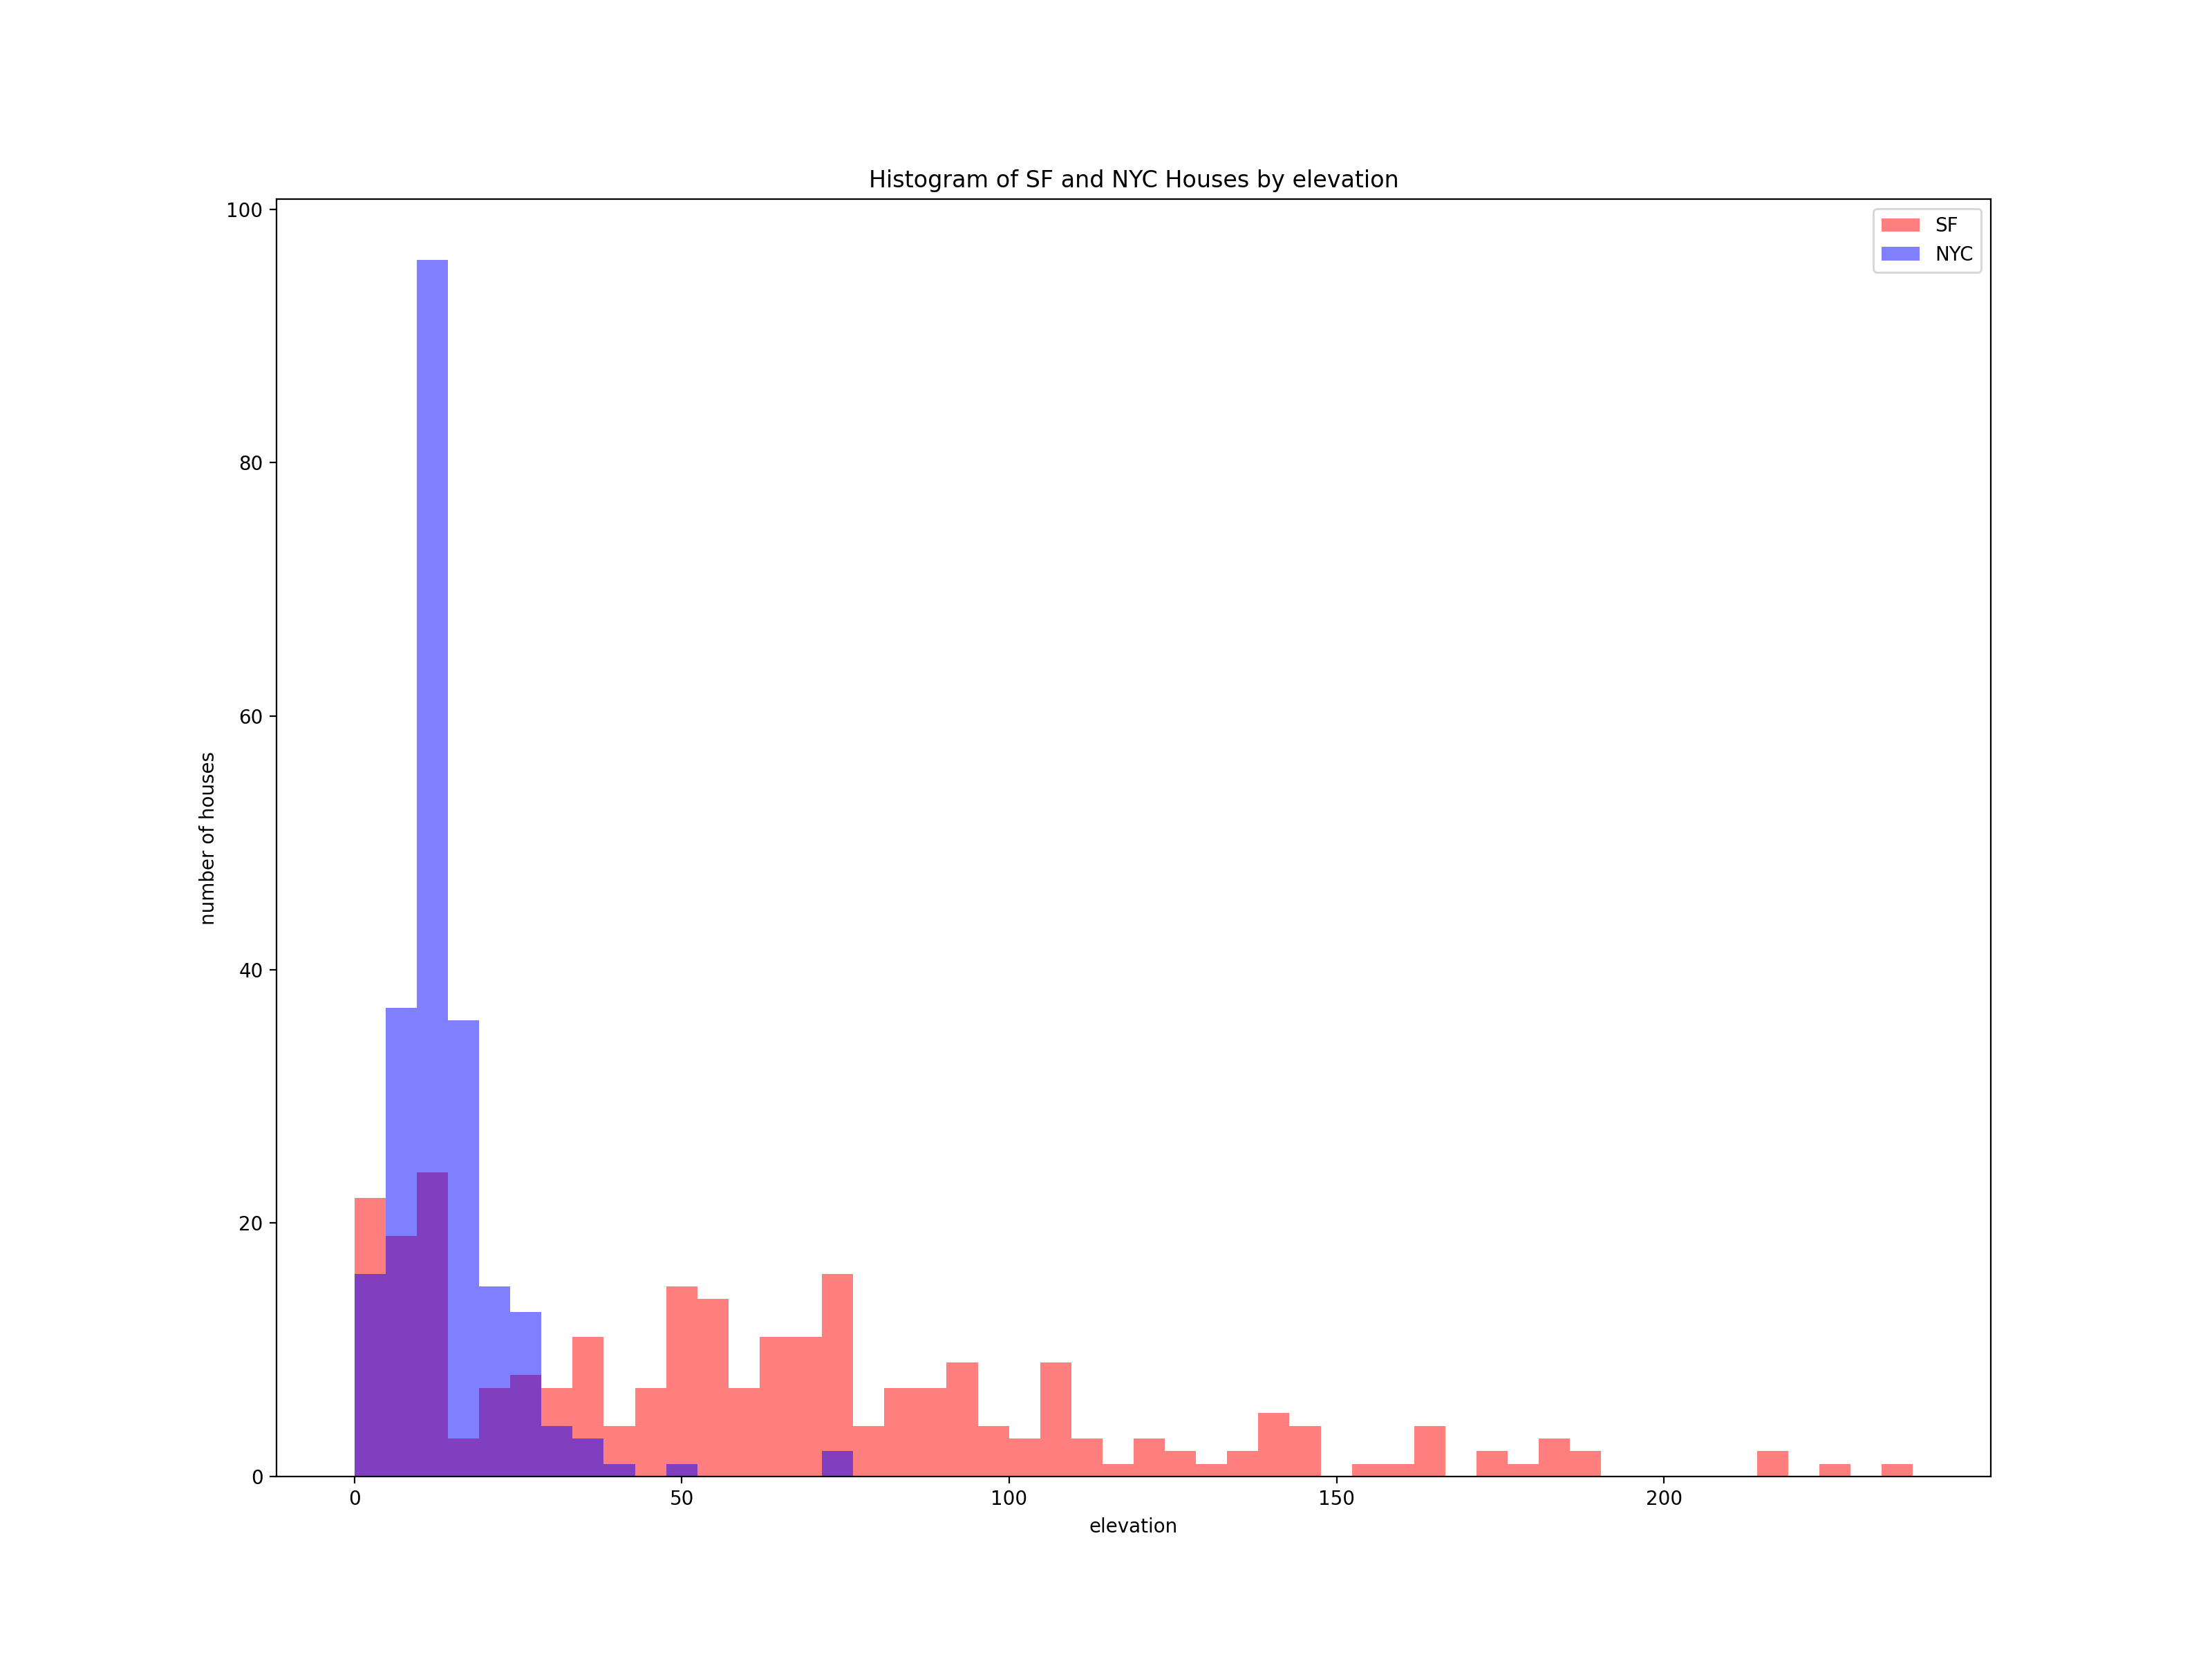

SF | mean: 61.86194029850746, std: 50.17714484595509, min: 0, max: 238
NYC | mean: 13.504464285714286, std: 9.402696121638057, min: 0, max: 73


In [4]:
# 1) explore the data
# available features are price, year_built, bath, beds, elevation, price_per_sqft
plot_housing_histogram('elevation')

In [6]:
# 2) Implement is_in_sf
def is_in_sf(feature):
    '''
    feature is a dictionary with the following keys: 
    - 'year_built'
    - 'price_per_sqft'
    - 'bath'
    - 'beds'
    - 'elevation'
    - 'price'
    
    return 1 if house is predicted to be in SF, 0 if NYC    
    '''
    ### Your Code Below ###
    return feature['elevation'] > 30

In [7]:
# 3) Test your performance!
num_correct = 0
sf_but_pred_ny = 0
total_num = len(features_c)
for i, feature in enumerate(features_c):
    prediction_in_sf = is_in_sf(feature)
    if prediction_in_sf == labels_c[i]:
        num_correct += 1
    else:
        if labels_c[i] and not prediction_in_sf:
            sf_but_pred_ny += 1
print("Got {:.2f}% correct!".format(num_correct/1./total_num*100))
print("Out of incorrect predictions, {:.2f}% were SF houses predicted to be in NYC".format(
                                                                                sf_but_pred_ny/1./(total_num - num_correct)*100))

Got 80.89% correct!
Out of incorrect predictions, 90.43% were SF houses predicted to be in NYC


### Part 1.2 The Perceptron Algorithm

In this section we will implement the perceptron algorithm, which will learn a linear decision boundary function $f(x)$ of the form:
$$
f(X_i) = \left\{
        \begin{array}{ll}
            1 & \quad w^\top X_i + b > 0 \\
            0 & \quad else
        \end{array}
    \right.
$$
You can think of this function as drawing a line in the feature space. If a data point is above this line, we'll say it's from SF. If a data point is below this line, we'll say it's from NYC. In the 1D case where there is only 1 feature used, $w$ would be the slope of the line, and $b$ the y-intercept.

<br />

Note that $f$ is *parameterized* by $w$ and $b$. So our goal is to find the $w$ and $b$ that best minimizes a *loss* function:
$$
L(X, y) = \frac{1}{N} \sum_{i=1}^{N} (f_{w, b}(X_i) - y_i)^2
$$

The learning update equations for the perceptron algorithm are:
$$
error = (w^\top x + b) - y
$$
$$
w = w + \alpha * error * x
$$
$$
b = b + \alpha * error
$$

<br />
The perceptron algorithm has 2 *hyperparameters*: the learning rate ($\alpha$) and the number of epochs to be trained on. In addition, we can also select a smaller set of features instead of using all of them to learn on (sometimes this performs better). Complete the steps below:
1. Implement the perceptron algorithm
2. Experiment w/ learning rate and epochs. How do these affect the train and test performance? Why?
3. Experiment w/ feature selection. Which features seem to work the best? Why?
4. Tweak the above settings to get the best test performance. 
5. If you used 2 or 3 features, you can run the visualization code to visualize the decision boundary.

In [8]:
# helper functions
def f(w, b, x):
    if w.dot(x) + b > 0:
        return 1
    else:
        return 0

def classification_accuracy(X, y, w, b):
    y_pred = [f(w, b, x) for x in X]
    return (1 - mean_absolute_error(y_pred, y))*100


In [9]:
# 1) Read this implementation. Try matching it with the pseudocode
def perceptron_learn_w_b(X_tr, y_tr, X_t, y_t, epochs, learning_rate, features_to_use=None, vis=False):
    '''
    Run the perceptron algorithm for epochs iterations
    Return w, b
    '''
    # dimensions
    N = X_tr.shape[0] # number of data points we have
    d = X_tr.shape[1] # dimension of a feature vector
    
    # initialize weights
    w = np.zeros(d) # a vector of 0's of size d
    b = 0 # bias starts at 0
    
    if vis and d in (2, 3):
        fig = plt.figure()
    
    # perceptron learning algorithm
    for t in range(epochs):
        for i in range(N):            
            x = X_tr[i]
            pred_y = f(w, b, x)
            error = y_tr[i] - pred_y
            
            ### begin student code ###
            w = w + learning_rate * error * x     
            b = b + learning_rate * error
            ### end student code ###
        
        if vis and d in (2, 3):
            fig.clf()
            visualize_perceptron(features_to_use, X_tr, y_tr, w, b, fig)
            fig.canvas.draw()
            sleep(1)
        
        # reporting accuracy
        train_accuracy = classification_accuracy(X_tr, y_tr, w, b)
        test_accuracy = classification_accuracy(X_t, y_t, w, b)
        #clear_output(wait=True)
        print('epoch={}/{} | train={:.2f}% | test={:.2f}%'.format(t+1, epochs, train_accuracy, test_accuracy))
                
    return w, b

In [10]:
# 2) Choose hyperparameters
epochs = 100
learning_rate = 0.1

In [11]:
# 3) Choose which features to use
# available features are 'bath', 'beds', 'year_built', 'price_per_sqft', 'elevation', 'price'
# experiment with a subset of these to find what works best
features_to_use_c = ['price_per_sqft', 'elevation'] # please use 2 or 3 features here

<IPython.core.display.Javascript object>


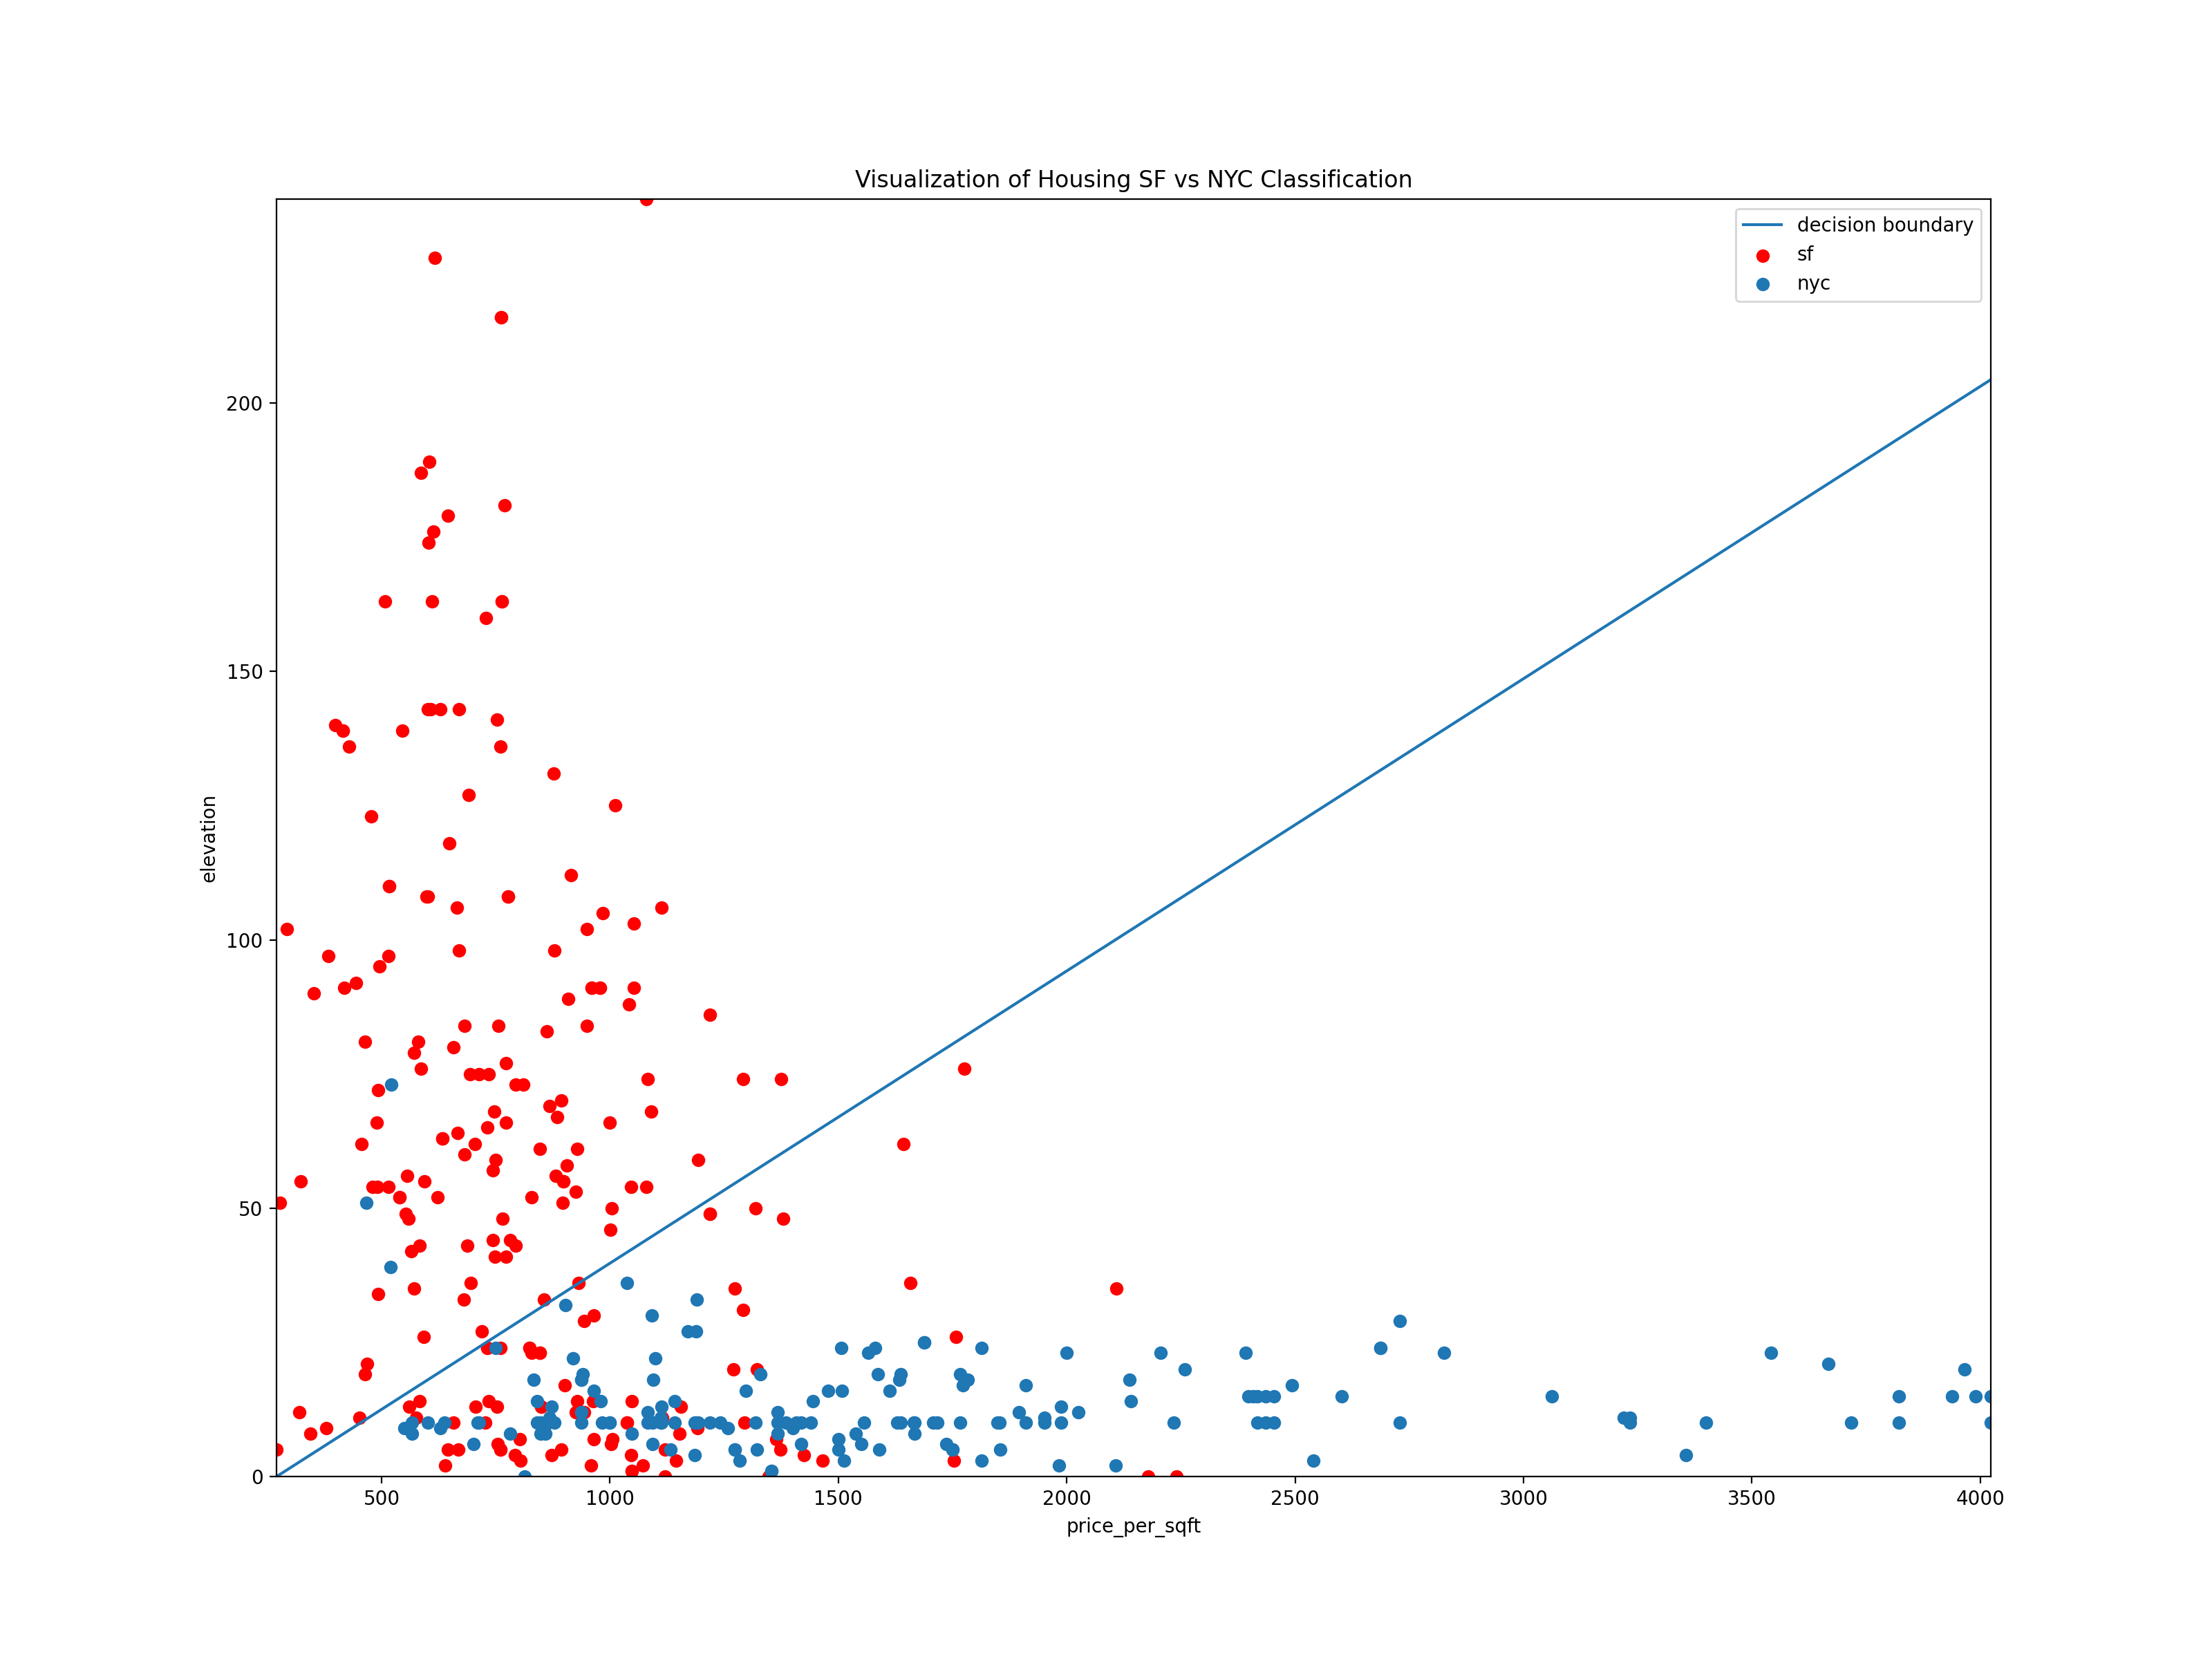

epoch=1/10 | train=57.51% | test=62.63%
epoch=2/10 | train=63.61% | test=67.68%
epoch=3/10 | train=56.74% | test=59.60%
epoch=4/10 | train=58.02% | test=63.64%
epoch=5/10 | train=60.05% | test=65.66%
epoch=6/10 | train=64.89% | test=67.68%
epoch=7/10 | train=74.30% | test=84.85%
epoch=8/10 | train=73.28% | test=83.84%
epoch=9/10 | train=74.55% | test=84.85%
epoch=10/10 | train=74.55% | test=84.85%
w is  [-106.2 1950.2] b is  36.60000000000025


In [12]:
# 4) Run this cell to train perceptron!
index_train_split = int(0.8 * len(features_c))
features_c_small = extract_cols(features_c, features_to_use_c)
features_c_train_array, features_c_test_array = features_c_small[:index_train_split], features_c_small[index_train_split:]
labels_c_train_array, labels_c_test_array = np.array(labels_c[:index_train_split]), np.array(labels_c[index_train_split:])

w_c, b_c = perceptron_learn_w_b(features_c_train_array, labels_c_train_array, features_c_test_array, labels_c_test_array, 
                            10, learning_rate, features_to_use=features_to_use_c, vis=True)
print('w is ', w_c, 'b is ', b_c)

<IPython.core.display.Javascript object>


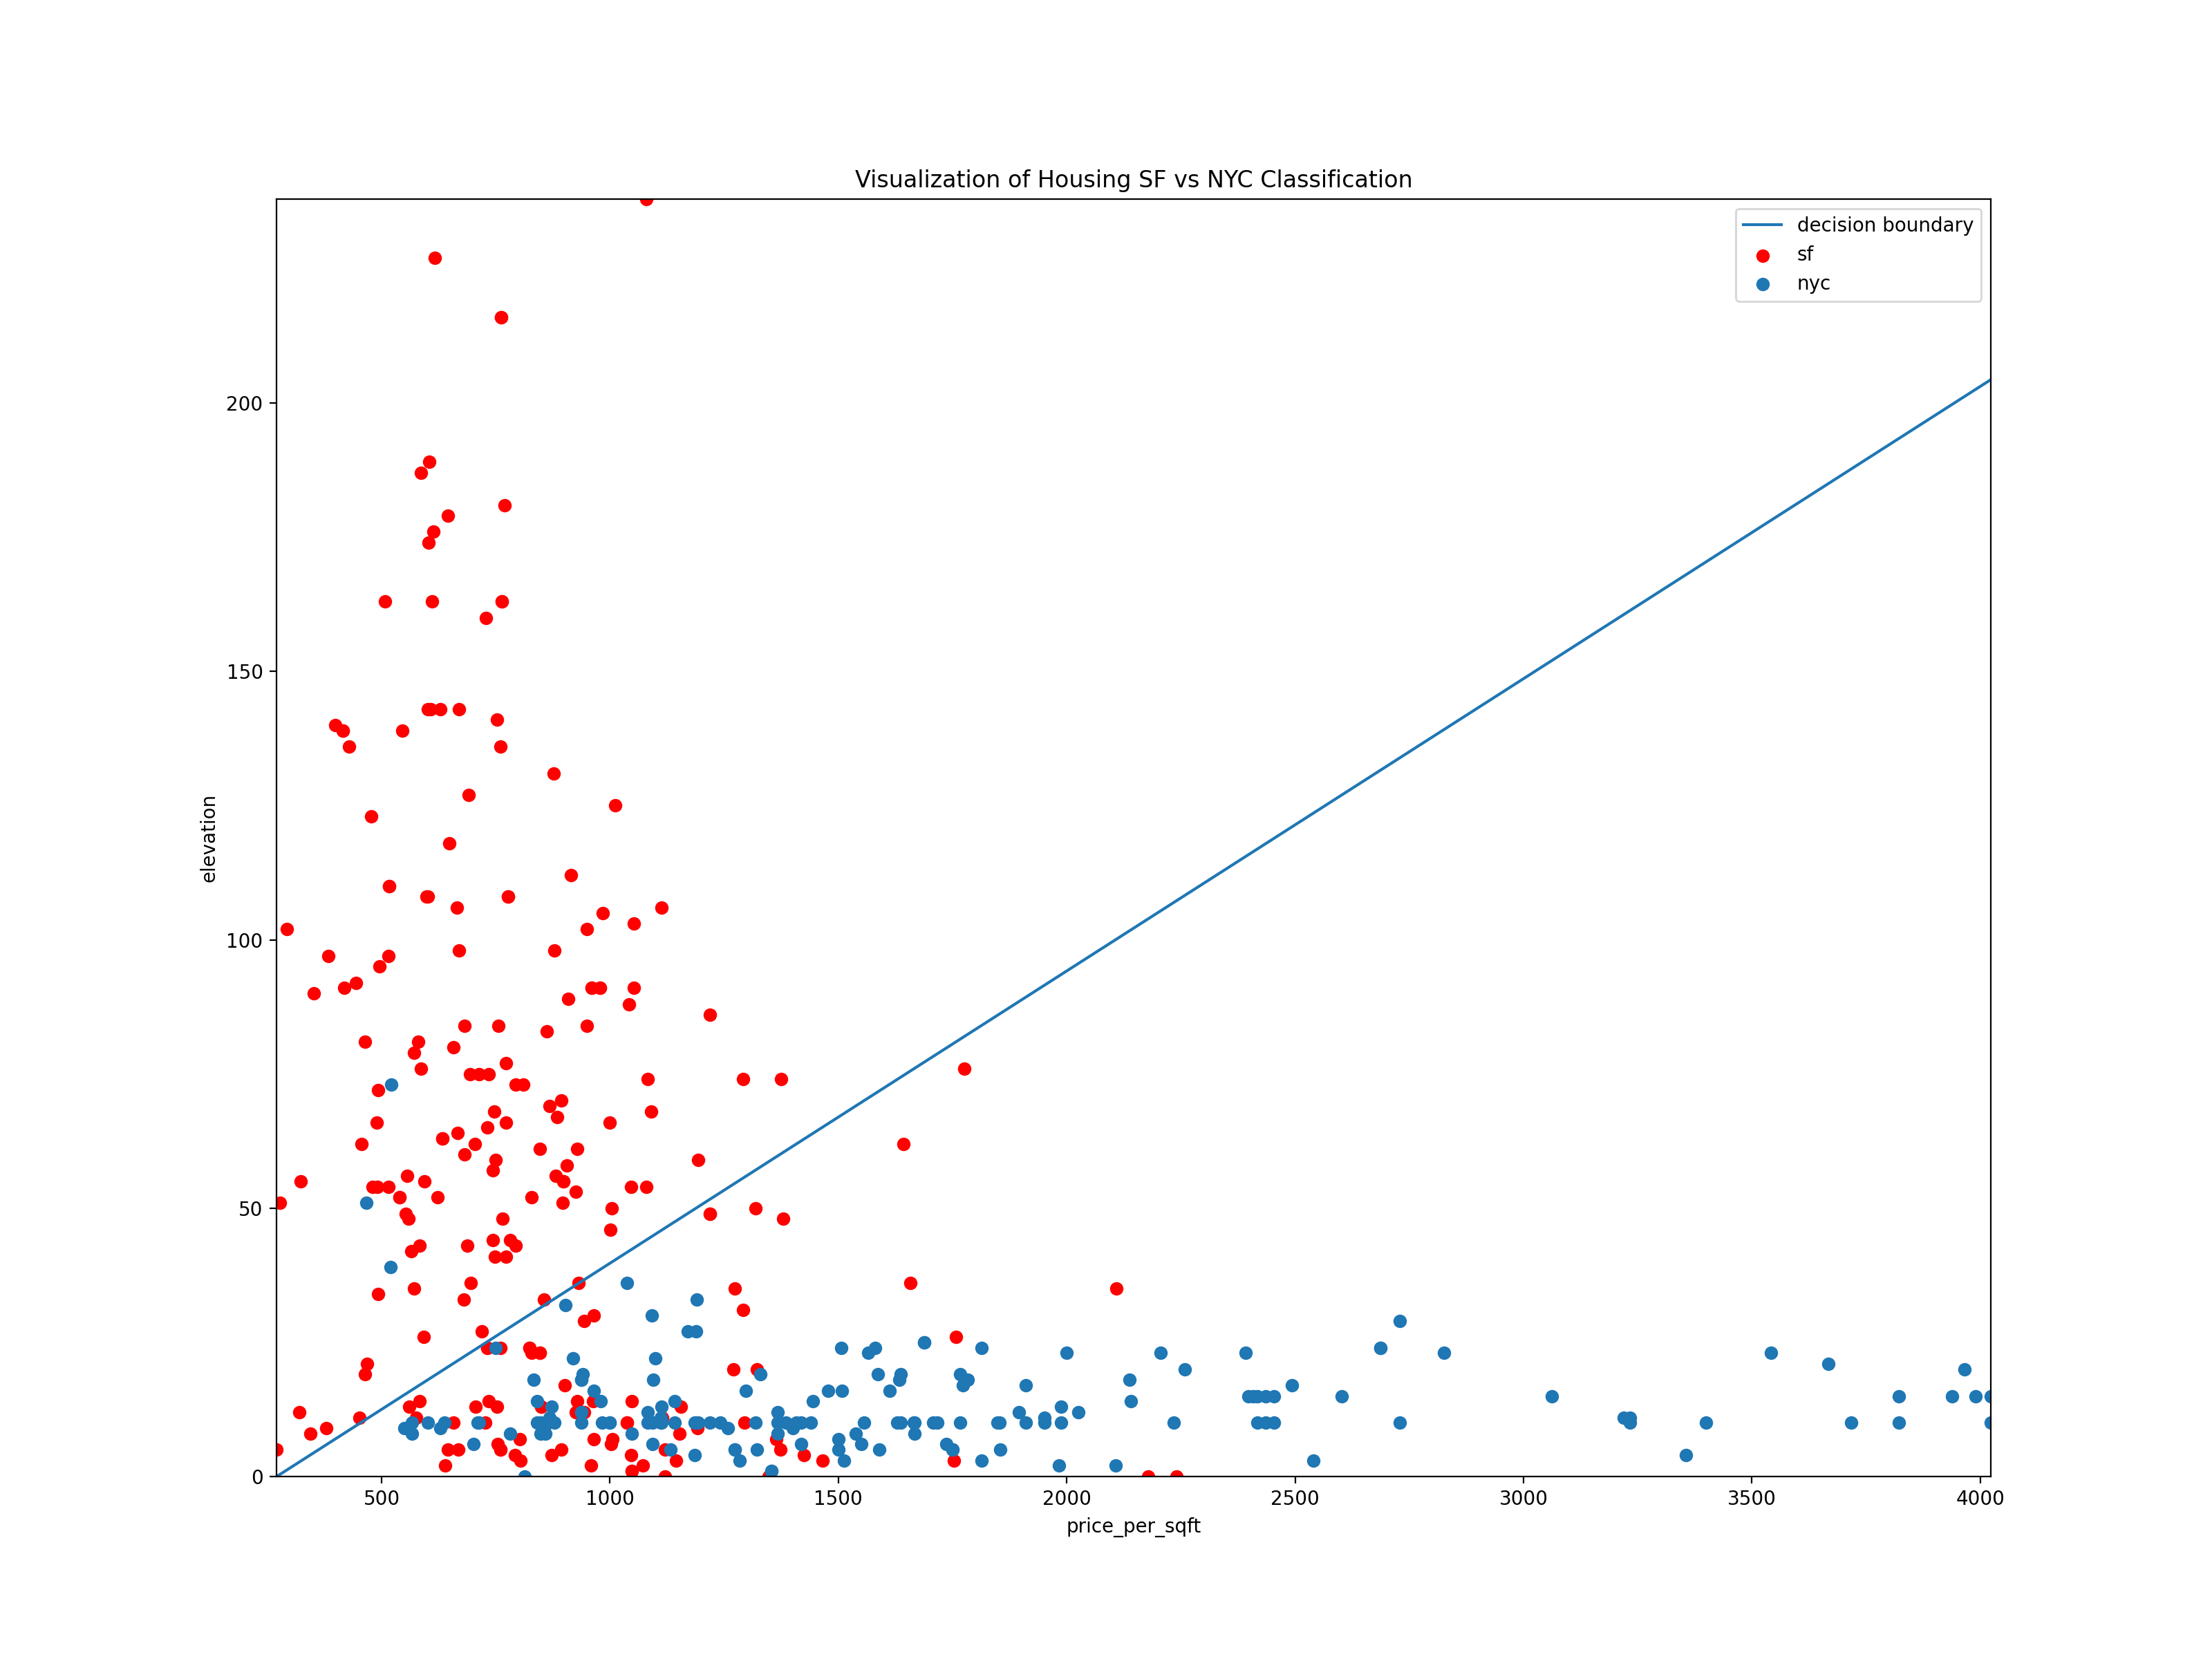

In [13]:
# 5) visualize data and learned decision boundary for 2 or 3 features
visualize_perceptron(features_to_use_c, features_c_train_array, labels_c_train_array, w_c, b_c)

## Part 2 Regression on Housing Price

In this section, our goal is to learn a model that predicts house prices. Our label is now "price" instead of "in_sf." "in_sf" is now included as a feature.

Regression, unlike classification, predicts a continuous range of values instead of discrete classes.

### Part 2.1 OLS for Expected House Price

In linear regression, we use a linear function to map from input features to output labels. Similar to the perceptron algorithm above, this model has the form:
$$
y_i = X_i^\top w
$$
The new $f$ for regression which outputs the predicted $y$ values will be:
$$
f(X_i) = X_i^\top w
$$
Our loss function will be the same as above:
$$
L(X, y) = \frac{1}{N} \sum_{i=1}^{N} (f_{w}(X_i) - y_i)^2
$$

We have a closed form solution for this problem. If $X$ is a matrix of features and $y$ the list of labels, then we can write:
$$
w = (X^\top X)^{-1} X^\top y
$$


To evaluate how good our predictor is, we compute two metrics - mean absolute error and the coefficient of determination (r2 score). Mean absolute error is the average absolute difference of our predicted house price and the true house price. This number however can be difficult to interpret, so we introduce another metric called the [coefficient of determination](https://en.wikipedia.org/wiki/Coefficient_of_determination), or r2 score. R2 scores roughly compute how good a set of predictions are given ground truth data. A higher r2 score means better predictions, and 100% accuracy correspond to an r2 score of 1. 

Complete the steps below:
1. Implement Linear Regression using $b$ as the mean of $y$ and $w$ the pseudoinverse of $X$
2. Experiment with which features to use to get the best performance
3. Run Linear Regression. Observe results.
4. Visualize the linear regression line for when using only 1 feature or 2 features.
5. Are the results good or bad? Why?

In [14]:
# 1) Implement OLS
def linear_regression(X_tr, y_tr, X_t, y_t):
    '''
    return weight vector w and bias b
    hints:
    - np.mean(x) returns the mean of x
    - np.linalg.pinv returns the pseudoinverse of x
    - a.dot(b) or a @ b returns the dot product of a and b
    '''
    ### begin student code ###
    w = np.linalg.inv(X_tr.T @ X_tr).dot(X_tr.T).dot(y_tr)
    ### End student code ##
    
    train_mae = regression_mae(X_tr, y_tr, w)
    test_mae = regression_mae(X_t, y_t, w)
    
    print("Train MAE {} | Test MAE {}".format(train_mae, test_mae))
    
    return w


def regression_mae(X, y, w):
    y_pred = X.dot(w)
    return mean_absolute_error(y_pred, y)

In [15]:
# 2) Choose which features to use
# available features are 'bath', 'beds', 'year_built', 'price_per_sqft', 'elevation', 'in_sf'
# experiment with a subset of these to find what works best
features_to_use_r = ['price_per_sqft', 'elevation']
# features_to_use_r = ['bath', 'beds', 'year_built', 'price_per_sqft', 'elevation', 'in_sf']

index_train_split = int(0.8 * len(features_r))
features_r_small = extract_cols(features_r, features_to_use_r)
features_r_biased = np.hstack((features_r_small, np.ones((len(features_r),1))))  # Adding column of ones for bias
features_r_train_array, features_r_test_array = features_r_biased[:index_train_split], features_r_biased[index_train_split:]
labels_r_train_array, labels_r_test_array = np.array(labels_r[:index_train_split]), np.array(labels_r[index_train_split:])

In [16]:
# 3) Run this cell to run linear regression
w_r = linear_regression(features_r_train_array, labels_r_train_array, features_r_test_array, labels_r_test_array)

# Computing linear regressor's r2 score using the linear regressor above
pred_tr_linear = features_r_train_array.dot(w_r)
pred_t_linear = features_r_test_array.dot(w_r)
pred_tr_linear_r2 = r2_score(pred_tr_linear, labels_r_train_array)
pred_t_linear_r2 = r2_score(pred_t_linear, labels_r_test_array)
print("Linear Regressor | Train r2 {:.2f}. Test r2 {:.2f}".format(pred_tr_linear_r2, pred_t_linear_r2))

print('w is ', w_r)

Train MAE 1070891.1101171568 | Test MAE 1056458.1182911482
Linear Regressor | Train r2 0.33. Test r2 0.48
w is  [    3143.00785065    10854.17856946 -2205521.48849435]


<IPython.core.display.Javascript object>


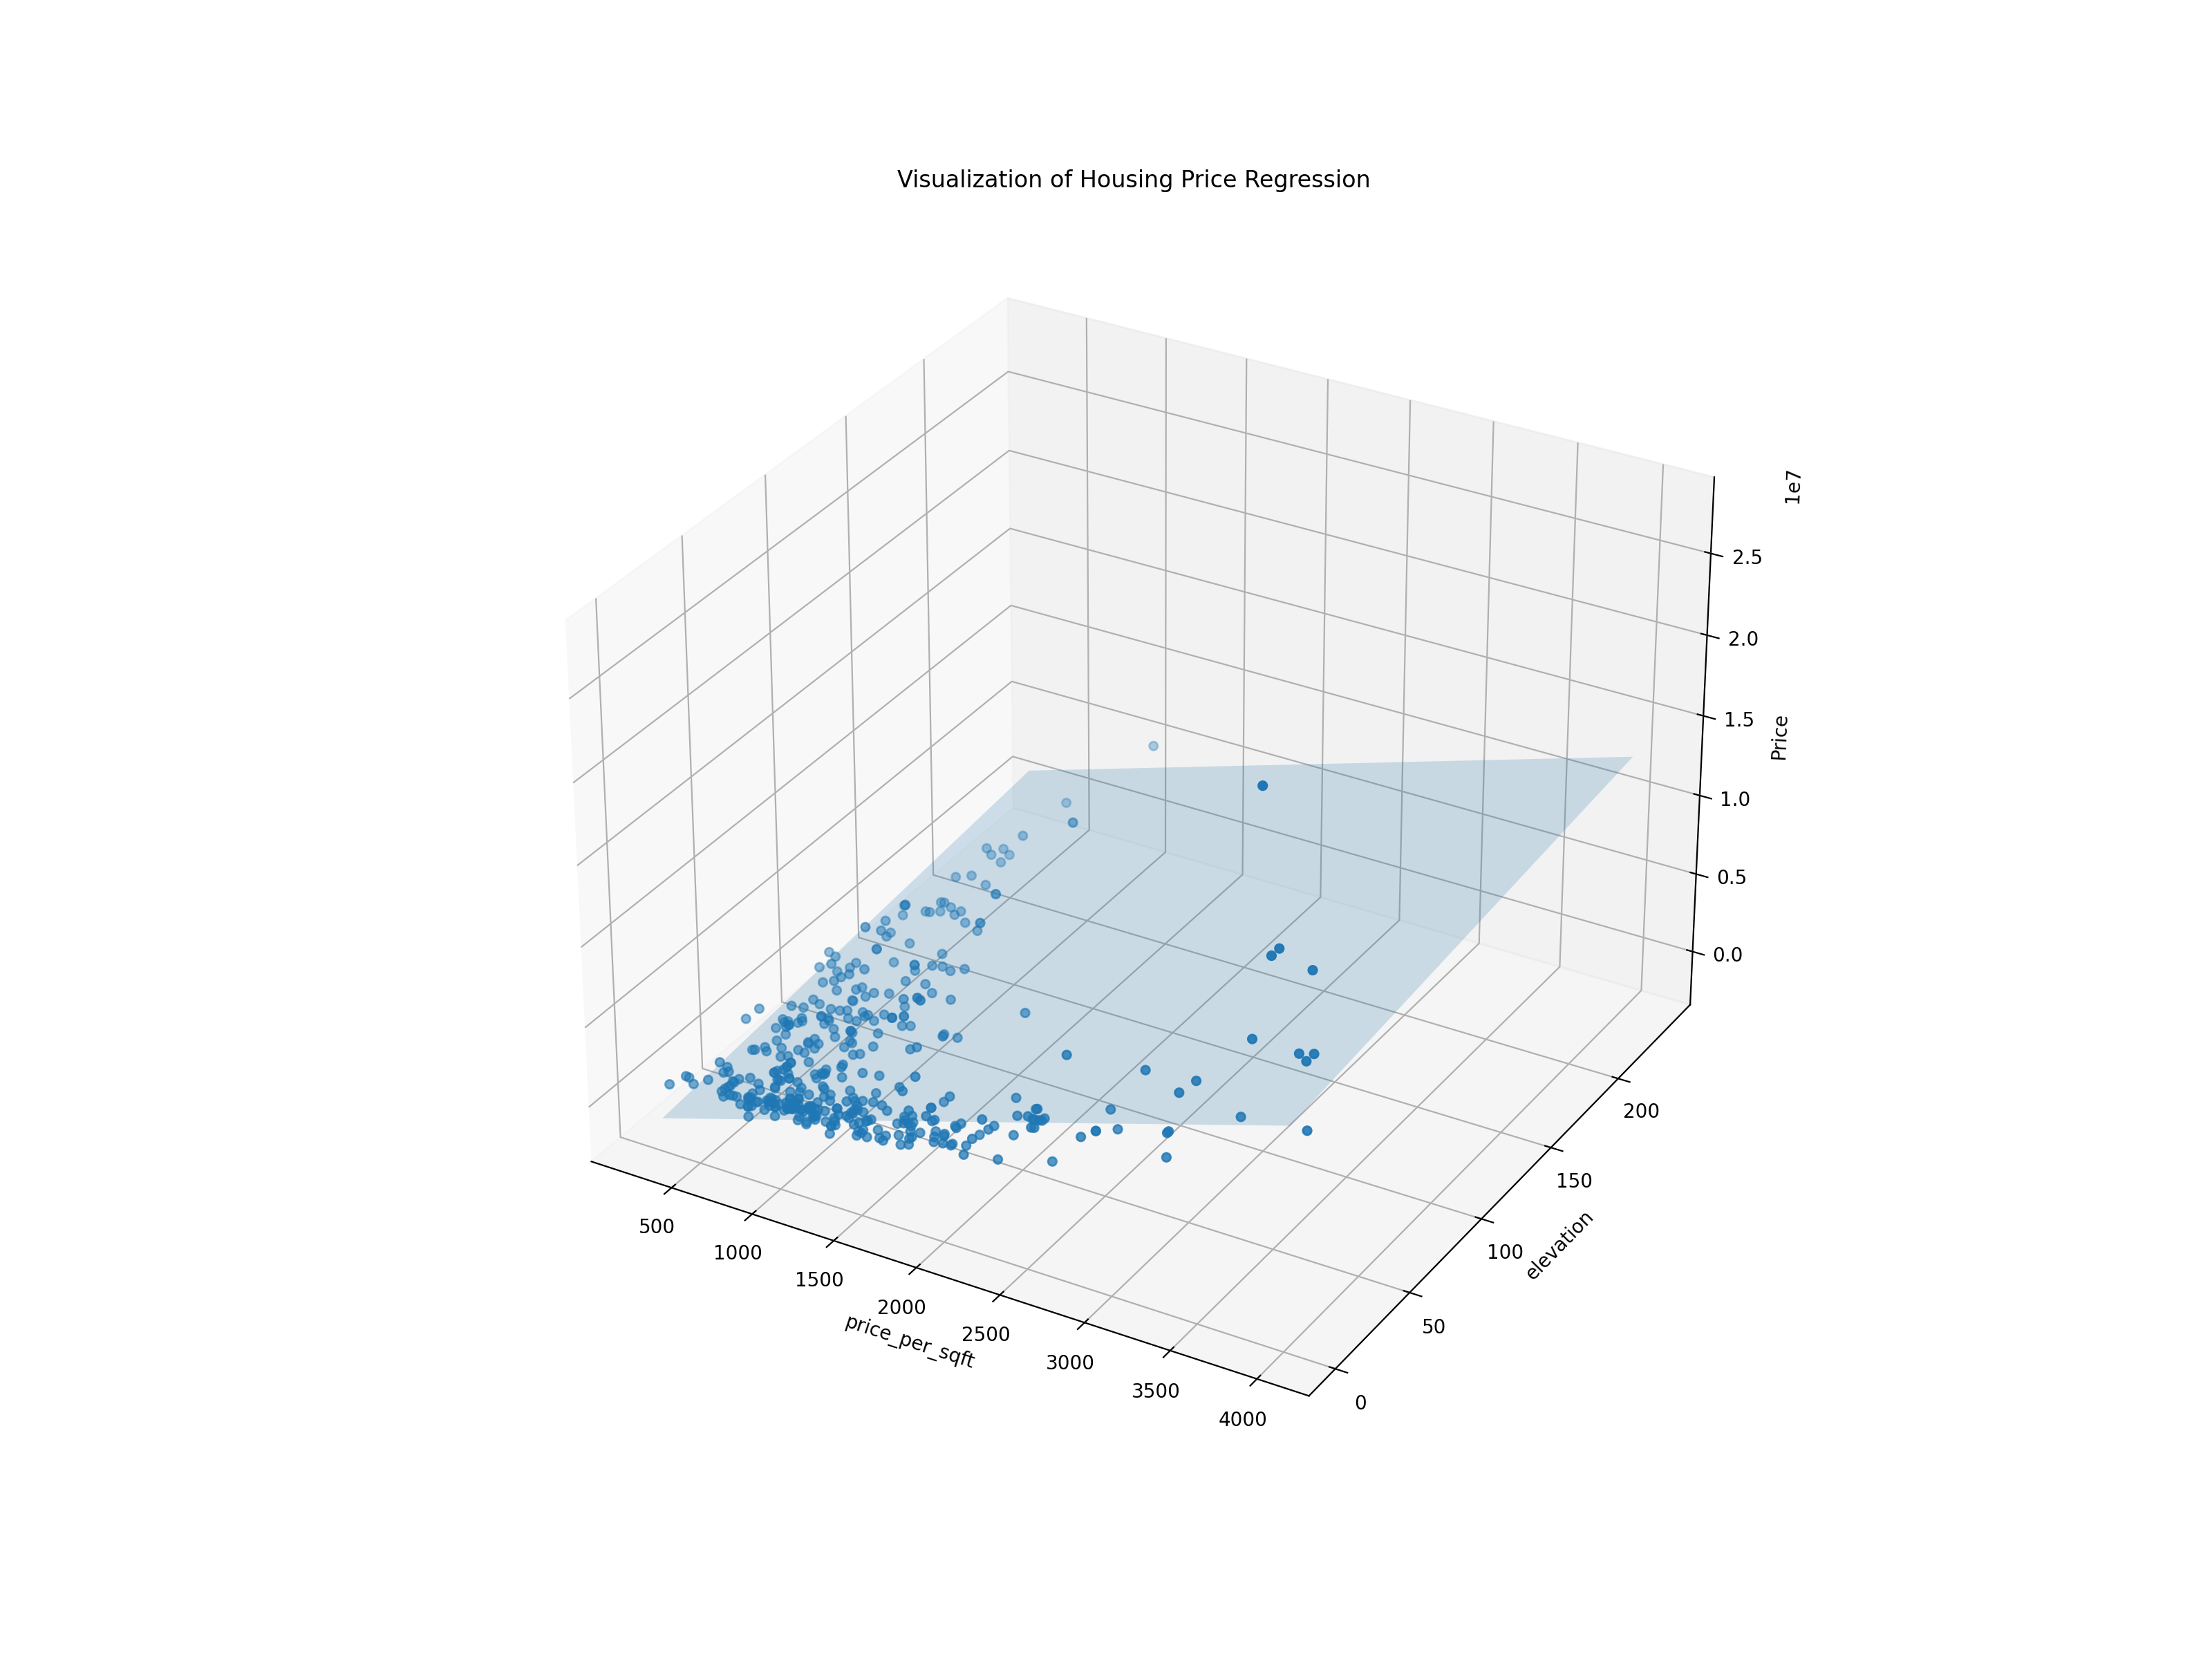

In [17]:
# 5) Visualize linear predictor for 1 or 2 features
visualize_linear_regression(features_to_use_r, features_r_train_array, labels_r_train_array, w_r)

### Part 2.2 Regression with Decision Tree

The main drawback of linear regression is that it is a model with low expressiveness (or representational power) - it can't fit to complex patterns in data. Another popular method in supervised learning is called Decision Tree. Below we demonstrate fitting this data using decision trees and show the improvements in prediction.

<br />
Complete the following steps:
1. Change the depth hyperparameter and run Decision Tree Regressor
2. Compute r2 scores for decision tree
3. Slowly increase the depth from:
    - What depth achieves the best train performance?
    - What depth achieves the best test performance?
    - At what depth does the test performance begin to decrease? Why?
4. Export and visualize decision tree using dot. Open .dot file, and copy the contents to this [site](http://dreampuf.github.io/GraphvizOnline/) to generate the visualization. Compare results with your neighbors. 
    - Which features are being split on? 
    - Which feature is the most important one?
    - Are these feature splits expected/surprising?

In [18]:
# 1) Train a Decision Tree Regressor
depth = 8 # Experiment with this value to see the balance between train and test performance
decision_tree = DecisionTreeRegressor(max_depth=depth)
features_dt_train, features_dt_test = features_r_small[:index_train_split], features_r_small[index_train_split:]
decision_tree.fit(features_dt_train, labels_r_train_array)

DecisionTreeRegressor(max_depth=8)

In [19]:
# 2) Compute decision tree regressor's MAE and r2 score
pred_tr_decisiontree = decision_tree.predict(features_dt_train)
pred_t_decisiontree = decision_tree.predict(features_dt_test)
pred_tr_decisiontree_r2 = r2_score(pred_tr_decisiontree, labels_r_train_array)
pred_t_decisiontree_r2 = r2_score(pred_t_decisiontree, labels_r_test_array)
print("Decision Tree Regressor | Train MAE {:.2f}. Test MAE {:.2f}".format(
                            mean_absolute_error(pred_tr_decisiontree, labels_r_train_array),
                            mean_absolute_error(pred_t_decisiontree, labels_r_test_array)))
print("Decision Tree Regressor | Train r2 {:.2f}. Test r2 {:.2f}".format(pred_tr_decisiontree_r2, pred_t_decisiontree_r2))

Decision Tree Regressor | Train MAE 315464.16. Test MAE 908911.04
Decision Tree Regressor | Train r2 0.97. Test r2 0.46


In [20]:
# 3) export decision tree
export_graphviz(decision_tree, out_file='decision_tree_regressor.dot', feature_names=features_to_use_r)

# view by entering command: dot -Tpng decision_tree_regressor.dot -o outfile.png